In [7]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

# create the universe
uni_config = godot.cosmos.util.load_yaml('universe2.yml')
uni = godot.cosmos.Universe(uni_config)

import mani_rain
from mani.StateEvaluator import SEEnum
from tqdm import tqdm
%matplotlib widget

In [18]:
class data_generator:
    def __init__(self, year, station, filepath='./output/year_sim', bandwidth=50e6):
        dict = {'AAU':SEEnum.CLEAR_MOON_AAU, 'NN11':SEEnum.CLEAR_MOON_NN}
        self._load_data(filepath, year)

        self.station_name = station

        self.condition = self.res.above_elev(station+'_elev', 10.0) & self.res.has([dict[station]])
        self.bandwidth = bandwidth

        self.set_link()
    
    def _load_data(self, filepath, year):
            filename = filepath+'/one_year_' + str(year) + '.pickle'
            with open(filename, 'rb') as f:
                self.res = pickle.load(f)
            self.res.add_los_coloumns()

    def set_science_rate_day(self, sc_rate):
        print(np.mean(self.res.has([SEEnum.SUN_ON_MOON])))
        print(60*60*24 * np.mean(self.res.has([SEEnum.SUN_ON_MOON])))
        sc = sc_rate / (60*60*24 * np.mean(self.res.has([SEEnum.SUN_ON_MOON])))
        self.science_rate = sc

    def set_target_data_rate(self, target_data_rate = 40e6):
        self.target_data_rate = target_data_rate
        self.full_data_rate = self.link.dvb_s2_fixed_rate(100, target_data_rate)

    def set_gateway_rate(self, gateway_rate = 16e6):
        self.gw_rate = gateway_rate
    
    def set_link(self):
        model_dict = {'AAU':mani_rain.rain.aau_ma_model,'NN11':mani_rain.rain.nn_model}
        station_dict = {'AAU':mani_rain.aalborg, 'NN11':mani_rain.new_norcia}

        mrm = mani_rain.markov_rain(station_dict[self.station_name], model_dict[self.station_name])
        self.link = mani_rain.link_budget_markov(station_dict[self.station_name], mrm, self.bandwidth)

    def get_rates(self):
        return self.full_data_rate, self.science_rate, self.gw_rate
    
    def simulate(self):
        res = self.res
        stat = self.station_name

        st_snrs = np.empty(res.get_length())
        st_rates = np.empty(res.get_length())

        for i in tqdm(range(res.get_length())):
            dist = res.df.iloc[i][stat+'_dist'] * 1e3
            elev = res.df.iloc[i][stat+'_elev']
            if self.condition[i]:
                st_snrs[i] = self.link.snr_at_t(dist, elev)
                st_rates[i] = self.link.dvb_s2_fixed_rate(st_snrs[i], self.full_data_rate)
            else:
                st_snrs[i] = np.nan
                st_rates[i] = 0

        self.gw_los = res.has([SEEnum.LOS_GW])
        self.comm_los = self.condition
        self.sun_on_moon = res.has([SEEnum.SUN_ON_MOON])
        self.st_rates = st_rates
        self.st_snrs = st_snrs

        return st_rates, st_snrs

    def get_outage_probability(self):
        #Following: Outage counter
        outage_counter = np.sum(self.condition & (st_rates == 0))
        outage_prob = (outage_counter/len(self.condition))
        print(f"Num samples: {len(self.condition)}, outages: {outage_counter}, outage prob: {outage_prob}")
        print(outage_prob)
        return outage_prob
    
    def plot_time(self):
        fig = plt.figure(figsize=(15, 4))
        ax0, ax1 = fig.subplots(1,2, sharex=True)
        ax0.plot(self.st_snrs)
        ax1.step(range(len(self.st_rates)), self.st_rates / 1e6, label = 'gs')
        ax1.step(range(len(self.gw_los)), self.gw_los * self.gw_rate / 1e6, label = 'gw')
        mean_rate = np.mean(self.st_rates[self.condition == True])
        ax1.axhline(mean_rate/1e6, color='tab:green', label='mean rate')
        ax1.set_ylabel('Rate Mbit')
        plt.show()
        

target_data_rate = 77 * 1e6
station = 'AAU'
dg = data_generator(year=2025, station=station, bandwidth=50e6)
dg.set_science_rate_day(25 * 1e9)
dg.set_target_data_rate(77 * 1e6)
dg.set_gateway_rate()
print(dg.science_rate)
st_rates, st_snrs = dg.simulate()

rate = dg.link.dvb.modcod_at_rate(np.max(st_rates))
print("Req snr:",rate.ebno)
rate = np.max(st_rates)
print("Rate:", rate)
print("dl/sc ratio:", rate/dg.science_rate)

0.49959760350532056
43165.23294285969
579169.8155108752


100%|██████████| 525601/525601 [00:20<00:00, 25964.16it/s]

Req snr: 2.992904442710109
Rate: 75211954.54545455
dl/sc ratio: 129.8616615216928


Num samples: 525601, outages: 15467, outage prob: 0.02942726516882578
0.02942726516882578


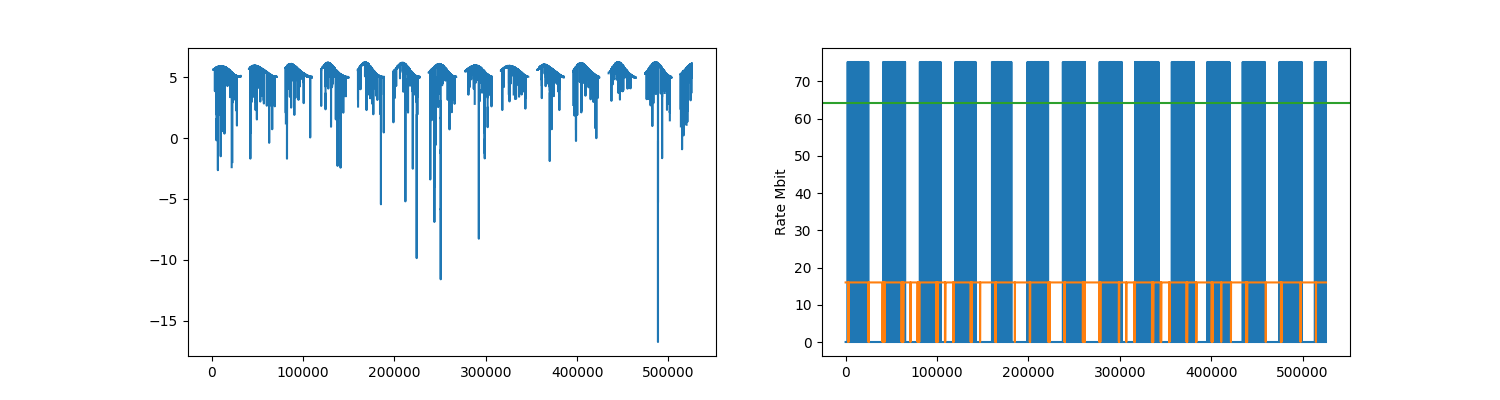

In [19]:
outage_prob = dg.get_outage_probability()
dg.plot_time()

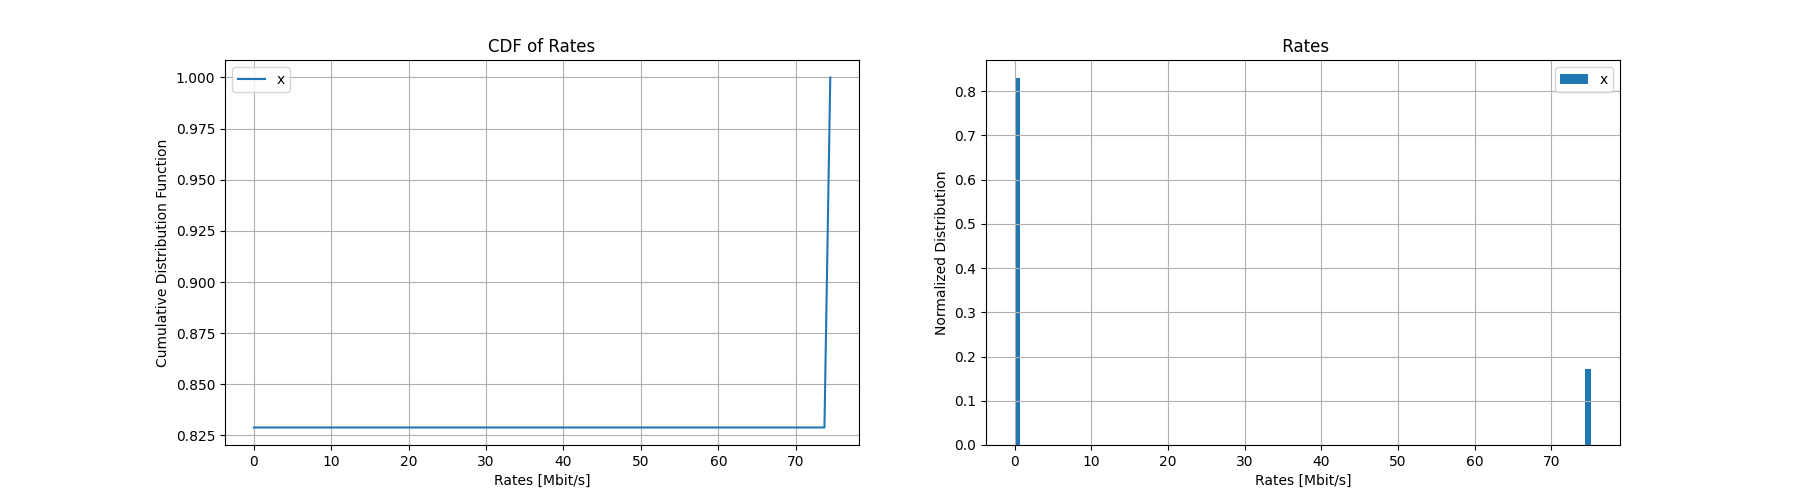

In [10]:
def plot_cdf(ax, bins,vals, name):
    ax.plot(bins[:-1], np.cumsum(vals), label = name)
    ax.grid()
    ax.set_xlabel('Rates [Mbit/s]')
    ax.set_ylabel('Cumulative Distribution Function')
    ax.legend()
    ax.set_title('CDF of Rates')

def plot_hist(ax, arr, name):
    ax.hist(arr, bins = 100, weights=np.ones(len(arr)) / len(arr), label = name)
    ax.grid()
    ax.set_xlabel('Rates [Mbit/s]')
    ax.set_ylabel('Normalized Distribution')
    ax.set_title(' Rates')
    ax.legend()

fig = plt.figure(figsize = (18,5))
ax0, ax1 = fig.subplots(1,2)
arr = st_rates / 1e6

name = 'x'
vals, bins = np.histogram(arr, bins=100, weights=np.ones(len(arr)) / len(arr))
plot_cdf(ax0, bins, vals, name)

plot_hist(ax1, arr, name)

plt.show()

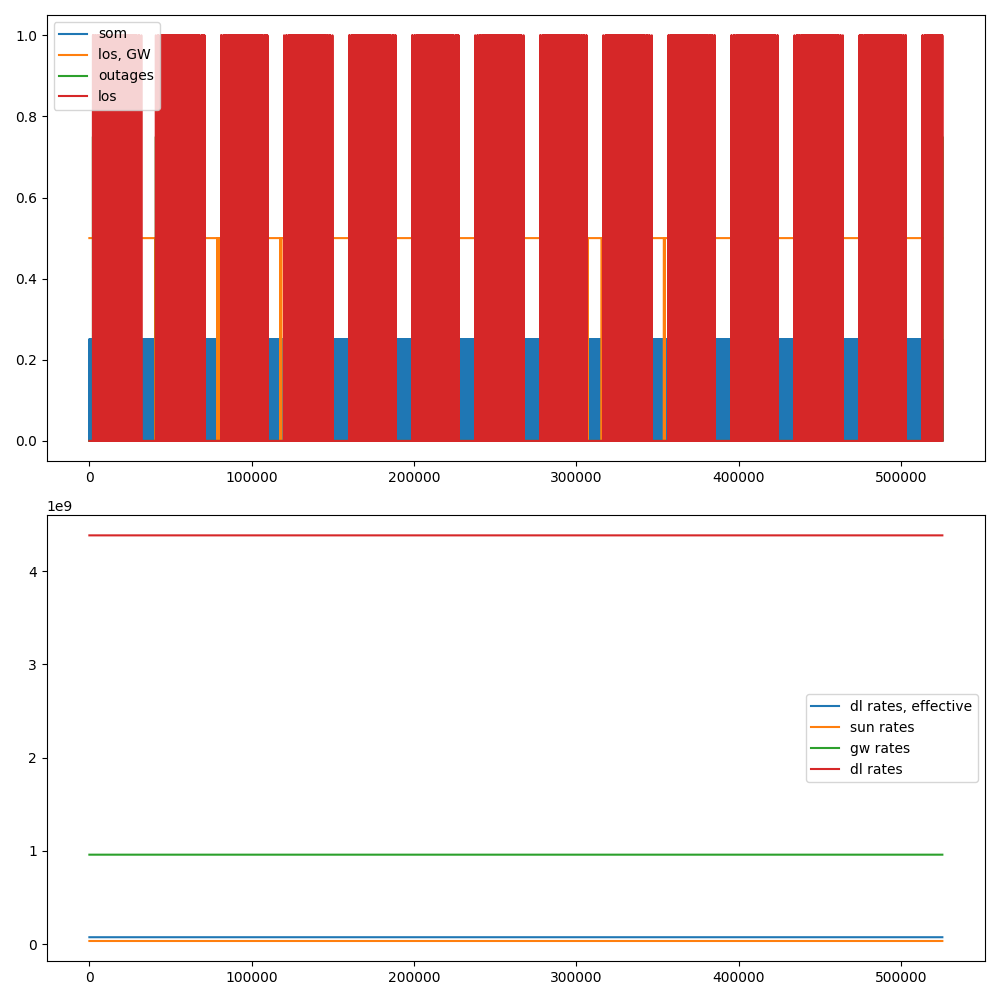

In [11]:
rd_raw, rs, gwr = dg.get_rates()
n = 0
m = dg.res.get_length()
rd =  rd_raw * (1 - outage_prob) * 60
rs = rs * 60
gwr = gwr * 60
dict = {'AAU':'los_aau', 'NN11':'los_nn'}
los = dg.res[dict[dg.station_name]][n:n+m].values
outs = (st_rates > 0)[n:n+m]
som = dg.res.has([SEEnum.SUN_ON_MOON])[n:n+m].values
gwlos = dg.res.has([SEEnum.LOS_GW])[n:n+m].values

def plot_exports(line_of_sight, outages, sunlight_on_moon, gateway_loss, science_rate, data_rate, gateway_rate, data_rate_raw):

    fig = plt.figure(figsize = (10,10))
    ax0, ax1 = fig.subplots(2,1)
    ax0.step(range(m), sunlight_on_moon*0.25, label = 'som')
    ax0.step(range(m), gateway_loss*0.5, label = 'los, GW')
    ax0.step(range(m), outages*0.75, label = 'outages')
    ax0.step(range(m), line_of_sight, label = 'los')
    ax0.legend()

    ax1.plot(range(m), [data_rate_raw]*m, label='dl rates, effective')
    ax1.plot(range(m), [science_rate]*m, label='sun rates')
    ax1.plot(range(m), [gateway_rate]*m, label= 'gw rates')
    ax1.plot(range(m), [data_rate]*m, label= 'dl rates')
    ax1.legend()
    plt.tight_layout()
    plt.show()

def export(line_of_sight, outages, sunlight_on_moon, gateway_loss, science_rate, data_rate, gateway_rate, data_rate_full, filepath='./tmp/'):
    os.makedirs(filepath, exist_ok=True)
    with open(filepath+'los.pickle', 'wb') as f:
        pickle.dump(line_of_sight,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'outage_los.pickle', 'wb') as f:
        pickle.dump(outages,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'som.pickle', 'wb') as f:
        pickle.dump(sunlight_on_moon,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'rs.pickle', 'wb') as f:
        pickle.dump(science_rate,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'rd.pickle', 'wb') as f:
        pickle.dump(data_rate,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'rd_raw.pickle', 'wb') as f:
        pickle.dump(data_rate_full,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'gwr.pickle', 'wb') as f:
        pickle.dump(gateway_rate,f,protocol=pickle.HIGHEST_PROTOCOL)

    with open(filepath+'gwlos.pickle', 'wb') as f:
        pickle.dump(gateway_loss,f,protocol=pickle.HIGHEST_PROTOCOL)


export(los, outs, som, gwlos, rs, rd, gwr, data_rate_full=rd_raw, filepath=f'./station_{station}_rate_{int(rate)}/')
plot_exports(los, outs, som, gwlos, rs, rd, gwr, rd_raw)

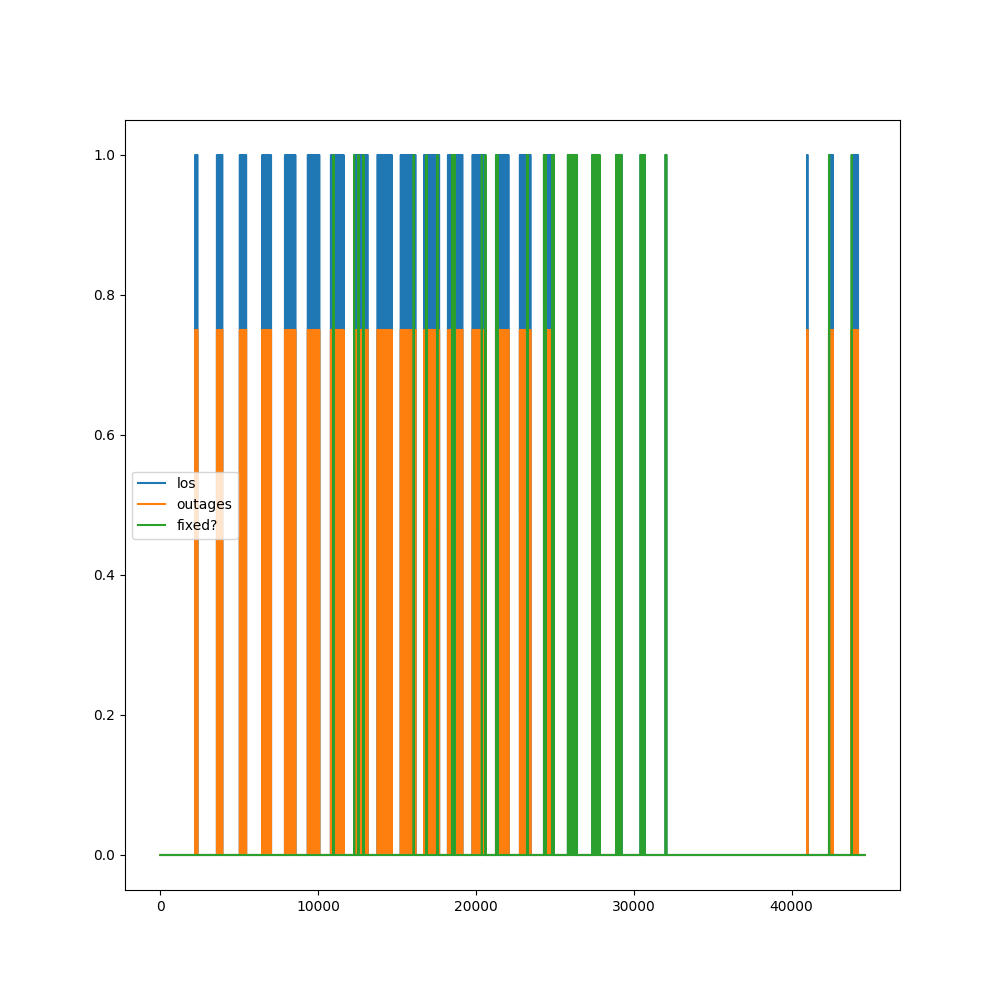

In [12]:
los = dg.res[dict[dg.station_name]][n:n+m].values
outs = (st_rates > 0)[n:n+m]

def plot_exports(line_of_sight, outages):

    fig = plt.figure(figsize = (10,10))
    ax0 = fig.subplots(1,1)
    ax0.step(range(len(line_of_sight)), line_of_sight, label = 'los')
    ax0.step(range(len(outages)), outages*0.75, label = 'outages')
    ax0.step(range(len(outages)), line_of_sight & (outages == False), label = 'fixed?')
    ax0.legend()

plot_exports(los[0:60*24*31], outs[0:60*24*31])

In [13]:
lat_deg =  57.0927889
lat =  np.radians(lat_deg)
lon = np.radians(9.8491639)

b = 6357 
a = 6378
z = (a - b) * (lat_deg / 90)
R = b + z

x = R * np.cos(lat) * np.cos(lon)

y = R * np.cos(lat) * np.sin(lon)

z = R * np.sin(lat)
print([x,y,z])

[3409.861022959618, 591.9989195310555, 5348.213067680093]


In [14]:
pi = P[0,:]
for i in range(int(1e7)):
    pi = pi @ P
print(pi)

NameError: name 'P' is not defined

[1.00000000e-01 7.07945784e-02 5.01187234e-02 3.54813389e-02
 2.51188643e-02 1.77827941e-02 1.25892541e-02 8.91250938e-03
 6.30957344e-03 4.46683592e-03 3.16227766e-03 2.23872114e-03
 1.58489319e-03 1.12201845e-03 7.94328235e-04 5.62341325e-04
 3.98107171e-04 2.81838293e-04 1.99526231e-04 1.41253754e-04
 1.00000000e-04]


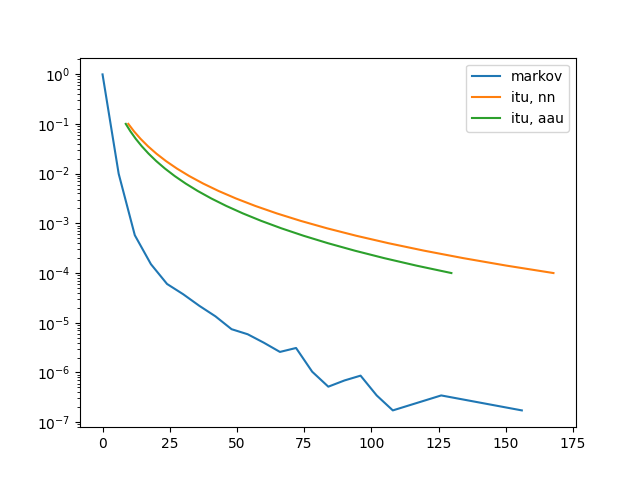

In [ ]:
nn = mani_rain.new_norcia
link_nn = mani_rain.link_budget_itu(nn, 100e6)
aau = mani_rain.station_t (
    lat = 57.014,
    lon = 9.986,
    height = 0.02,
    frequency = 32,
    gt = 41.55,
    diamaeter = 5.6)
link_aau = mani_rain.link_budget_itu(aau, 50e6)

props = np.logspace(-1, -4, 21)
print(props)
rates_nn = np.empty_like(props)
rates_aau = np.empty_like(props)
for i, p in enumerate(props):
    link_nn.rain_model.p = p
    link_aau.rain_model.p = p
    rates_nn[i] = link_nn.rain_model.rain_rate
    rates_aau[i] = link_aau.rain_model.rain_rate
plt.figure()
plt.plot(states_values*60, pi, label = 'markov')
plt.plot(rates_nn, props, label = 'itu, nn')
plt.plot(rates_aau, props, label = 'itu, aau')
plt.yscale('log')
plt.legend()
plt.show()